# Candidate Structure Generation and Simplified Comparisons to PA and EHSS

`Ctrl+Enter` to run a cell

* For PyMol interactions this program must be operating in the background and executed with the `-R` flag (e.g. `pymol -R`)

## Relevent References for IMS: 
https://link.springer.com/article/10.1007/s13361-012-0391-1

## Useful links:
- https://www.cresset-group.com/2017/02/boosting-rdkit-molecular-simulations-through-openmm/
- http://asteeves.github.io/blog/2015/01/12/conformations-in-rdkit/
- https://iwatobipen.wordpress.com/2012/10/21/%E3%81%A1%E3%82%87%E3%81%A3%E3%81%A8%E6%94%B9%E5%A4%89%E3%80%82/


In [1]:
import sys
from rdkit import Chem
from rdkit.Chem import AllChem

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
from rdkit.Chem import Descriptors3D as d3d
from rdkit.Chem import PyMol

In [4]:
DrawingOptions.bondLineWidth=1.8

In [5]:
txaSmiles = []
txaSmiles.append('CCC[N+](CCC)(CCC)CCC')#T3A
txaSmiles.append('CCCC[N+](CCCC)(CCCC)CCCC')#T4A
txaSmiles.append('CCCCC[N+](CCCCC)(CCCCC)CCCCC')#T5A
txaSmiles.append('CCCCCCC[N+](CCCCCCC)(CCCCCCC)CCCCCCC')#T7A
txaSmiles.append('CCCCCCCC[N+](CCCCCCCC)(CCCCCCCC)CCCCCCCC')#T8A
txaSmiles.append('CCCCCCCCCC[N+](CCCCCCCCCC)(CCCCCCCCCC)CCCCCCCCCC')#T10A
txaSmiles.append('CCCCCCCCCCCC[N+](CCCCCCCCCCCC)(CCCCCCCCCCCC)CCCCCCCCCCCC')#T12A

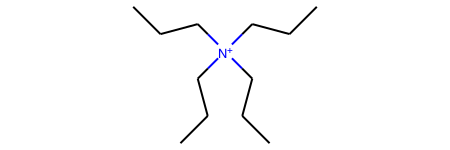

In [6]:
t3a = Chem.MolFromSmiles('CCC[N+](CCC)(CCC)CCC')
t3a

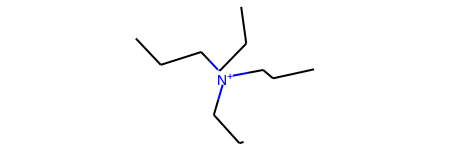

In [7]:
AllChem.EmbedMolecule(t3a)
t3a

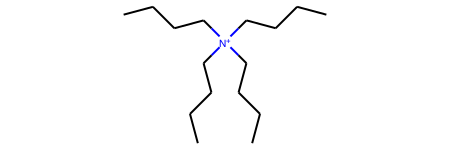

In [8]:
t4a = Chem.MolFromSmiles('CCCC[N+](CCCC)(CCCC)CCCC')
t4a

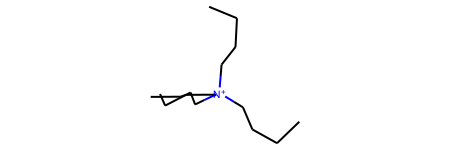

In [9]:
AllChem.EmbedMolecule(t4a)
t4a

In [10]:
mol = t3a
# mol = t4a
mol=Chem.AddHs(mol)

### Observations:
- MMFF optimize is called but the approach function call is extremely quick so it is unclear how much optimization is performed on the TXA compounds.
- For the optimization of ibuprofen (see separate ipynb) this process appears to work. 

In [11]:
def generateRadii(mol, numConf = 50, maxIters = 3000):
    '''
    Generates a list of all the radii of gyration for the different conformers
    
    Currently the number of conformers generated are trimmed based upon RMS differences to the original structure.
    As detailed in the documentation, this is a greed process.  Larger pruneRmsThresh may be needed for larger molecules
    to generate a sufficient number of conformers
    
    MMFF optimize is called but the approach function call is extremely quick so it is unclear whether this is really
    working as intended.  Additional investigation my be required
    
    '''
    AllChem.EmbedMolecule(mol)
    cids = AllChem.EmbedMultipleConfs(mol, clearConfs=True, numConfs=numConf, pruneRmsThresh=1)
#     cids = AllChem.EmbedMultipleConfs(mol, numConfs=numConf, params=AllChem.ETKDG())
#     cids = list(cids)
    for cid in cids:
        retVal = AllChem.MMFFOptimizeMolecule(mol, confId=cid, maxIters=maxIters)
    rmslist = []
    AllChem.AlignMolConformers(mol, RMSlist=rmslist)
    mol = Chem.RemoveHs(mol)
    radii = []
    for cid in cids:
        radii.append(d3d.RadiusOfGyration(mol, confId = cid, useAtomicMasses = True))
    radii = np.array(radii, dtype = np.float)
    print(radii.mean(), radii.std(), len(radii))
    return radii

In [12]:
radii = generateRadii(mol, 10)

2.70259309288551 0.03536129308921112 10


#### Generate radii for all of the compounds shown in the SMILES list.

In [13]:
rList = []
for i,t in enumerate(txaSmiles):
    print("Processing #%d: %s"%(i,t))
    mol = Chem.MolFromSmiles(t)
    rList.append(generateRadii(mol, numConf = 100))

Processing #0: CCC[N+](CCC)(CCC)CCC
2.6335914469365456 0.00862749664729998 19
Processing #1: CCCC[N+](CCCC)(CCCC)CCCC
3.302917919395399 0.01811726017169159 58
Processing #2: CCCCC[N+](CCCCC)(CCCCC)CCCCC
4.010953846938492 0.023596692651288175 95
Processing #3: CCCCCCC[N+](CCCCCCC)(CCCCCCC)CCCCCCC
5.317144624102059 0.1363453668751037 99
Processing #4: CCCCCCCC[N+](CCCCCCCC)(CCCCCCCC)CCCCCCCC
5.922301005809036 0.22527664841794348 97
Processing #5: CCCCCCCCCC[N+](CCCCCCCCCC)(CCCCCCCCCC)CCCCCCCCCC
7.122788378858431 0.5302924031127597 49
Processing #6: CCCCCCCCCCCC[N+](CCCCCCCCCCCC)(CCCCCCCCCCCC)CCCCCCCCCCCC
8.707017222868727 0.20784530281891525 4


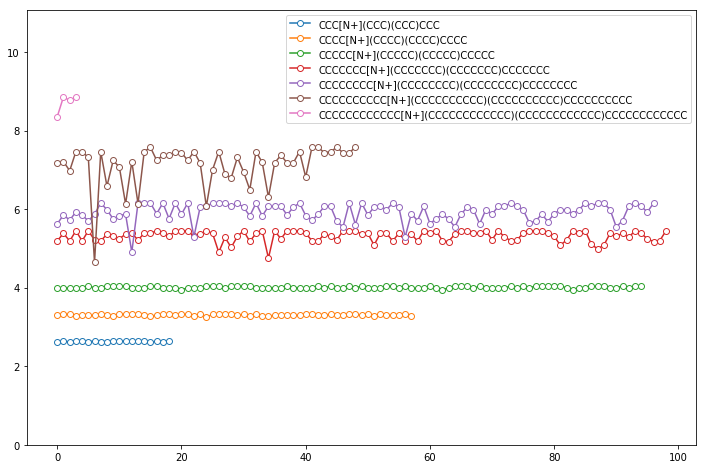

In [14]:
fig= plt.figure(figsize=(12,8))
rMax = 0.0
for i,r in enumerate(rList):
    label = txaSmiles[i]
    plt.plot(r, 'o-', mfc = 'white', label = label)
    curMax = r.max()
    if curMax>rMax:
        rMax = curMax

plt.ylim(0, rMax*1.25)
plt.legend(loc='upper right')

## Write xyz file from mol file.
- Be mindful of the number of conformations associated with a given mol instance.
- This format can be useful for future input into additional computations (e.g. ccs values)

In [15]:
def write_xyz_input_file(fragment, fragment_name):
    '''
    https://github.com/jensengroup/take_elementary_step
    '''
    number_of_atoms = fragment.GetNumAtoms()
    charge = Chem.GetFormalCharge(fragment)
    symbols = [a.GetSymbol() for a in fragment.GetAtoms()]
    fNames = []
    for i,conf in enumerate(fragment.GetConformers()):
        file_name = fragment_name+"_"+str(i)+".xyz"
        fNames.append(file_name)
        with open(file_name, "w") as file:
            file.write(str(number_of_atoms)+"\n")
            file.write("title\n")
            for atom,symbol in enumerate(symbols):
                p = conf.GetAtomPosition(atom)
                line = " ".join((symbol,str(p.x),str(p.y),str(p.z),"\n"))
                file.write(line)
            if charge !=0:
                file.write("$set\n")
                file.write("chrg "+str(charge)+"\n")
                file.write("$end")
    print("Complete")
    return fNames

### Example instance of saveing a mol file with 1 conformer

In [22]:
mol = t3a
# mol = t4a
mol=Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
cids = AllChem.EmbedMultipleConfs(mol, clearConfs=True, numConfs=1, pruneRmsThresh=1)
for cid in cids:
    retVal = AllChem.MMFFOptimizeMolecule(mol, confId=cid, maxIters=3000)
rmslist = []
AllChem.AlignMolConformers(mol, RMSlist=rmslist)
fn = write_xyz_input_file(mol, 'T3A_Test')
print(fn)

Complete
['T3A_Test_0.xyz', 'T3A_Test_1.xyz', 'T3A_Test_2.xyz', 'T3A_Test_3.xyz', 'T3A_Test_4.xyz', 'T3A_Test_5.xyz', 'T3A_Test_6.xyz', 'T3A_Test_7.xyz', 'T3A_Test_8.xyz', 'T3A_Test_9.xyz', 'T3A_Test_10.xyz', 'T3A_Test_11.xyz', 'T3A_Test_12.xyz', 'T3A_Test_13.xyz', 'T3A_Test_14.xyz', 'T3A_Test_15.xyz', 'T3A_Test_16.xyz', 'T3A_Test_17.xyz', 'T3A_Test_18.xyz', 'T3A_Test_19.xyz']


## Projection Approximation and Exact Hard Spheres Calculation
* https://github.com/jmwoll/tau
* Issues:
    * It is unclear the identity of the pairing neutral.
    * Currently assumed to be Helium

In [17]:
from tau import tau, ehs

In [18]:
paccs = tau.pa_ccs(xyzfile = fn[0], radii = 'mobcal')

skipping line:
$set
skipping line:
chrg 1
skipping line:
$end


In [19]:
paccs

95.34680422046954

In [21]:
np.sqrt(paccs/np.pi)

5.509068015500065

### The EHS call is extremely slow
* Investigate the GO implementation or some other call

In [247]:
ccs = ehs.ehs_ccs(xyzfile = fn[0])#TAKES FOREVER
ccs

No radii specified loading default radii:
cite these parameters as:
parameters are:

skipping line:
$set
skipping line:
chrg 1
skipping line:
$end
[('C', 3.0505748290759844, -1.60429448206995, -1.8350617160303317), ('C', 1.9928425001773582, -1.4060866487117927, -0.756777973707352), ('C', 0.8776998560459609, -0.48596716532832757, -1.2581115058243677), ('N', -0.1791315705724059, -0.05656404145726258, -0.19085001906580423), ('C', -0.4376942271746006, -1.2209288340810096, 0.8099333434750459), ('C', -1.50257393920363, -0.9237039804979575, 1.868267779973095), ('C', -1.6237942900748883, -2.086182508364691, 2.8457567434252122), ('C', 0.23521468079089491, 1.2599703549271621, 0.517555254580865), ('C', 1.4524133254186518, 1.1495580597675104, 1.4306618352716602), ('C', 1.6717407109806053, 2.4524599841883714, 2.1904279098775614), ('C', -1.5306983525491746, 0.21275787544823252, -0.949668351061213), ('C', -1.4200093407793983, 1.227328558332332, -2.092743495273823), ('C', -2.765377041480264, 1.3968978

116.30132547032127

In [248]:
np.sqrt(ccs/np.pi)

6.08439493076197

-------

### Additional scripts that may prove useful.

In [54]:
# The parameters (molecule and number of conformers) are passed via a Python
def generateconformations(m, n):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, numConfs=n, params=AllChem.ETKDG())
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids)

### Display Molecular Conformers

In [23]:
v= PyMol.MolViewer()

In [26]:
v.server.do('set grid_mode, off')

In [28]:
v.DeleteAll()
for cid in cids: 
    v.ShowMol(mol,confId=cid,name='Conf-%d'%cid,showOnly=False)

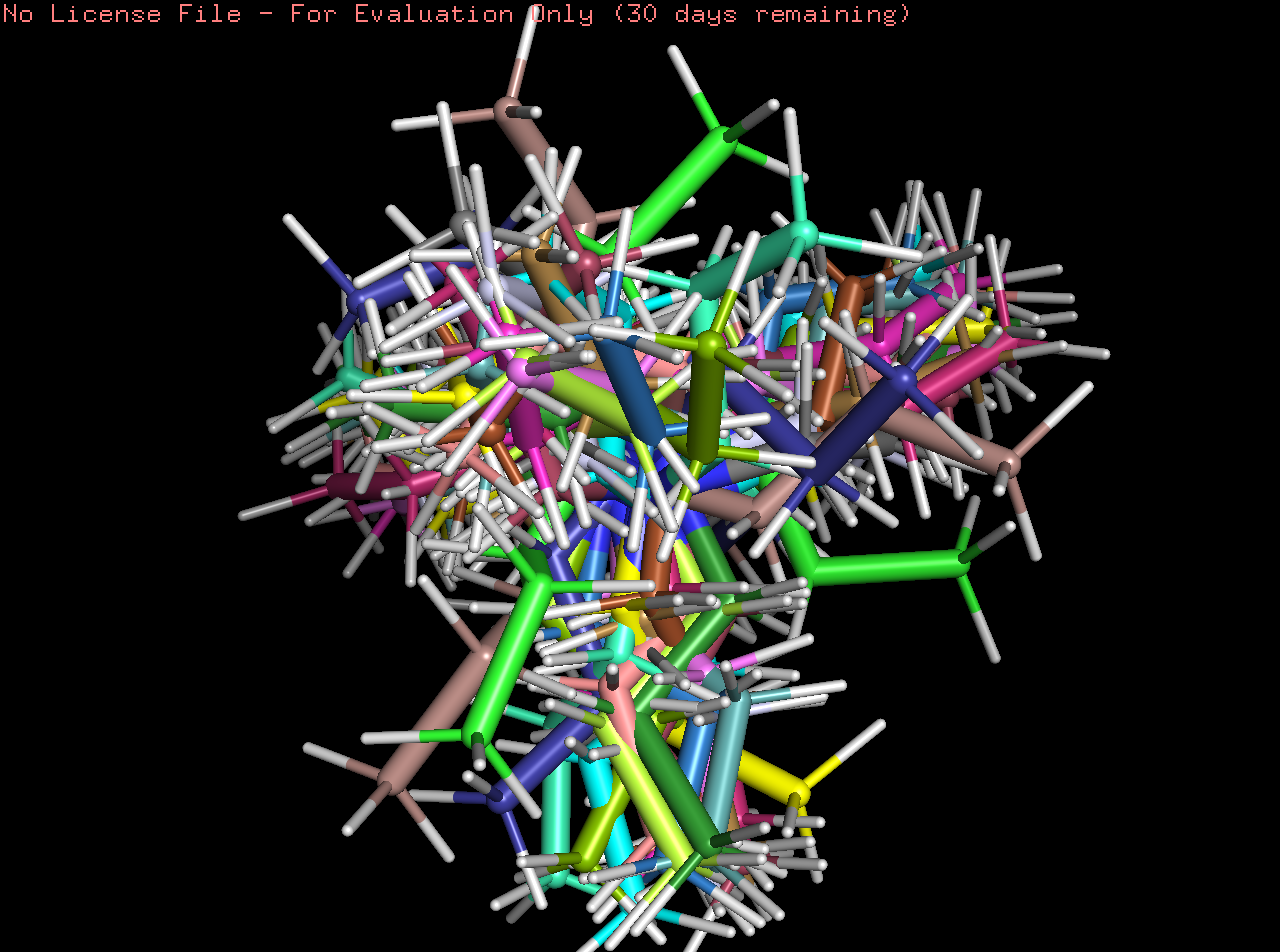

In [29]:
v.GetPNG()

In [30]:
v.server.do('set grid_mode, on')

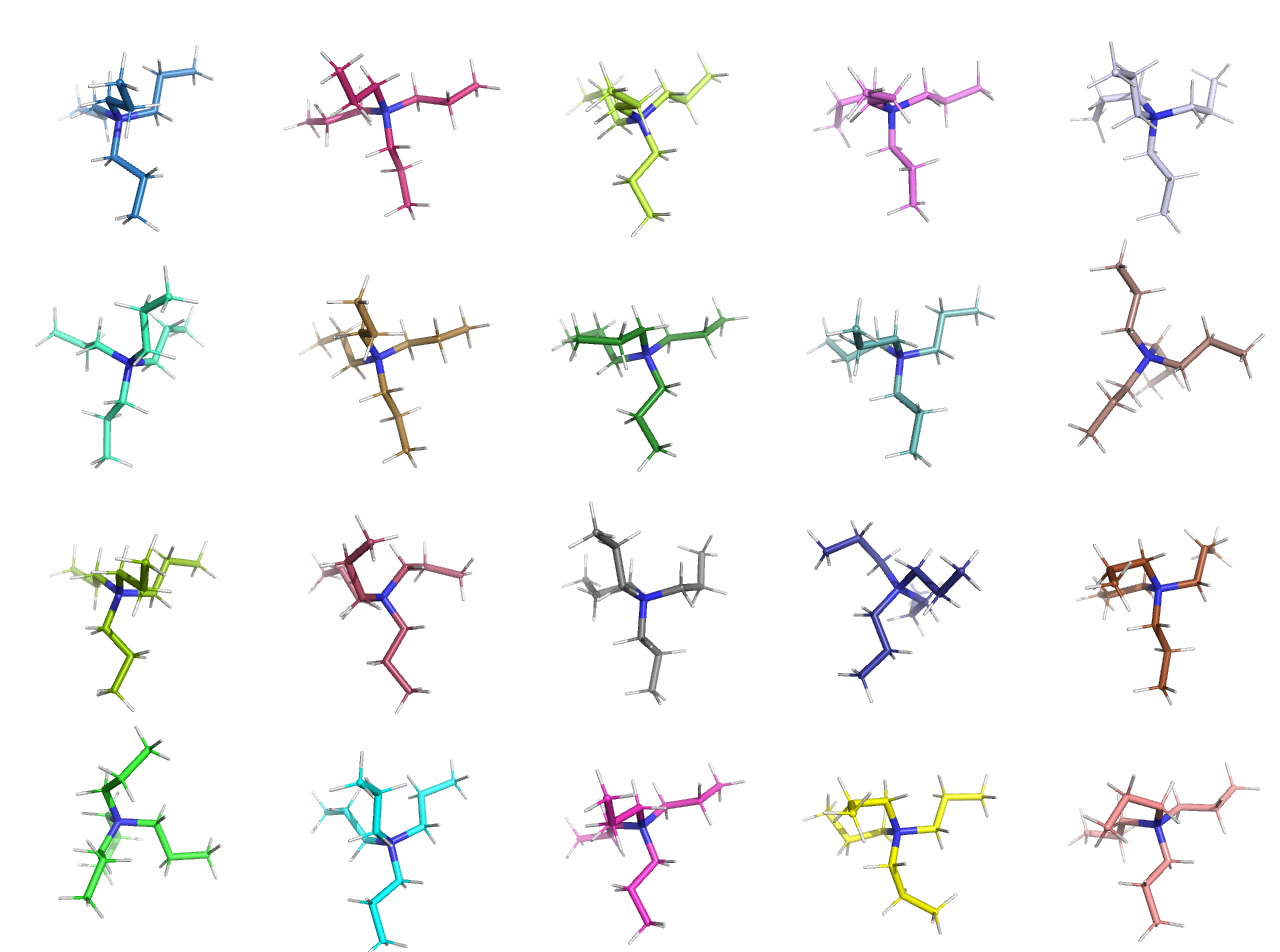

In [31]:
v.server.do('ray')
v.GetPNG()

### Experimentally determined values of TXA salts determined at room temperature at WSU (Fall 2018)

![Image of Ko](https://github.com/bhclowers/scriptorium/blob/master/images/KoDriftGases.png?raw=true)

### Saves all conformers in the sdf format. 

In [69]:
sdf_output_file = 't3aConf.sdf'

n = 100

# sdf_output_file = sys.argv[1:3]

# n = int(sys.argv[3])

writer = Chem.SDWriter(sdf_output_file)

In [157]:
mol = t3a
# mol = t4a
mol=Chem.AddHs(mol)

In [71]:
conf, ids = generateconformations(mol, n)
for i in ids:
#     print(i, conf)
    writer.write(conf, confId=i)
writer.close()

In [125]:
for cid in cids:
    retVal = AllChem.MMFFOptimizeMolecule(mol,confId=cid, maxIters=1000)

In [123]:
cids = AllChem.EmbedMultipleConfs(mol, 
                                  clearConfs=True, 
                                  numConfs=50, 
                                  pruneRmsThresh=1)

#### Align Conformers

In [126]:
rmslist = []
AllChem.AlignMolConformers(mol, RMSlist=rmslist)

In [127]:
mol = Chem.RemoveHs(mol)

#### Molecular Descriptors

In [128]:
print(d3d.RadiusOfGyration(mol))

2.577566481504297


In [133]:
d3d.PMI1(mol)

581.4432567291816

In [134]:
d3d.PMI2(mol)

699.4372105025301

In [135]:
d3d.PMI3(mol)

820.4227962185182

In [136]:
d3d.NPR1(mol)

0.7087117269402582

In [137]:
d3d.NPR2(mol)

0.8525326377160248

In [138]:
d3d.Asphericity(mol)

0.03880501985172019

In [139]:
d3d.Eccentricity(mol)

0.7054981843331397

In [140]:
d3d.SpherocityIndex(mol)

0.6574026912190074

In [141]:
d3d.InertialShapeFactor(mol)

0.0014662353167733243

In [148]:
radii = []
for cid in cids:
    radii.append(d3d.RadiusOfGyration(mol, confId = cid, useAtomicMasses = True))
radii = np.array(radii, dtype = np.float)

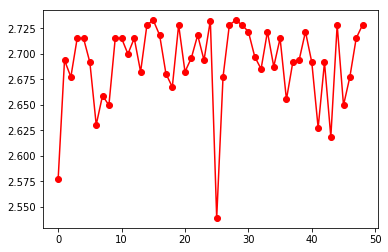

In [150]:
plt.plot(radii, 'ro-')